In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import logbook
from datetime import datetime
import pytz

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pyfolio as pf

import zipline
from zipline import TradingAlgorithm
from zipline.api import order_target, symbol, history, schedule_function, date_rules, time_rules
from zipline.algorithm import TradingAlgorithm
from zipline.finance import commission, slippage

In [3]:
%load_ext zipline
%matplotlib inline

In [ ]:
# !zipline ingest

## Get Benchmark Returns

In [4]:
with pd.HDFStore('../00_data/assets.h5') as store:
    benchmark_ret = store['sp500/prices'].close.pct_change()
benchmark_ret.index = benchmark_ret.index.tz_localize('UTC')    
benchmark_ret.head()

date
1789-05-01 00:00:00+00:00         NaN
1789-06-01 00:00:00+00:00    0.000000
1789-07-01 00:00:00+00:00   -0.019608
1789-08-01 00:00:00+00:00    0.020000
1789-09-01 00:00:00+00:00    0.000000
Name: close, dtype: float64

## Run Algo

In [ ]:
% % zipline - -start 2010-1-1 - -end 2018-1-1 - o results/results_5_50_95_0.pickle

import pandas as pd
import numpy as np
from zipline.finance import commission, slippage
from zipline.api import get_datetime, set_benchmark

MA_SHORT = 10
MA_LONG = 50
BOTTOM_Q = .025
TOP_Q = .95
MAX_SHORT = -0.25
MAX_LONG = 0.25

with pd.HDFStore('../00_data/assets.h5') as store:
    STOCKS = store.get('quandl/wiki/stocks/sp500').symbol


def initialize(context):
    context.stocks = STOCKS
    context.sids = [context.symbol(symbol) for symbol in context.stocks]

    context.i = 0
    context.ma_short = MA_SHORT
    context.ma_long = MA_LONG
    context.top_q = TOP_Q
    context.bottom_q = BOTTOM_Q
    context.max_s = MAX_SHORT
    context.max_l = MAX_LONG

    context.set_commission(commission.PerShare(cost=0))
    context.set_slippage(slippage.FixedSlippage(spread=0))

    # portfolio constraints
    context.max_leverage = 1.0
    context.max_pos_size = 0.015
    context.max_turnover = 0.95

    attach_pipeline(
        make_pipeline(),
        'data_pipe'
    )
    attach_pipeline(
        risk_loading_pipeline(),
        'risk_pipe'
    )

    # schedule rebalancing
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(),
    )


def before_trading_start(context, data):
    """Run pipelines and store result in context"""
    context.output = pipeline_output('data_pipe')

    context.risk_factor_betas = pipeline_output('risk_pipe')
    
def make_pipeline():

    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
        mask=QTradableStocksUS()
    )

    return Pipeline(
        columns={
            'sentiment_score': sentiment_score,
        },
        screen=sentiment_score.notnull()
    )

In [13]:
%%zipline --start 2010-1-1 --end 2018-1-1 -o results/results_5_50_95_0.pickle

import pandas as pd
import numpy as np
from zipline.finance import commission, slippage
from zipline.api import get_datetime, set_benchmark

MA_SHORT = 10
MA_LONG = 50
BOTTOM_Q = .025
TOP_Q = .95
MAX_SHORT = -0.25
MAX_LONG = 0.25

with pd.HDFStore('../00_data/assets.h5') as store:
    STOCKS = store.get('quandl/wiki/stocks/sp500').symbol

def initialize(context):
    context.stocks = STOCKS
    context.sids = [context.symbol(symbol) for symbol in context.stocks]

    context.i = 0
    context.ma_short = MA_SHORT
    context.ma_long = MA_LONG
    context.top_q = TOP_Q
    context.bottom_q = BOTTOM_Q
    context.max_s = MAX_SHORT
    context.max_l = MAX_LONG    
    context.years = []

    context.set_commission(commission.PerShare(cost=0))
    context.set_slippage(slippage.FixedSlippage(spread=0))

    
def handle_data(context, data):

    lt = context.ma_long
    context.i += 1
    if context.i < lt:
        return

    now = get_datetime()
    if now.month == 1:
        if now.year not in context.years:
            print(now.date())
            context.years.append(now.year)

    bottom, top = context.bottom_q, context.top_q
    ma = {'st': context.ma_short, 'lt': lt}
    stocks = [s for s in context.sids if data.can_trade(s)] 
#               if s.start_date <= now 
#               and s.end_date >= now]

    hist = {m: data.history(stocks, 'price', bar_count=w, frequency='1d') for m, w in ma.items()}
    mavg = {m: hist[m].add(1).fillna(1).prod().sub(1).pow(1/hist[m].count()) for m, w in ma.items()}
    std = hist['lt'].std()

    dev = mavg['st'].sub(mavg['lt'])
    q = dev.quantile(q=[bottom, top])

    long = (dev >= max(q[top], 0)).astype(int)
    long = long.div(std).clip(lower=0, upper=context.max_l)
    if long.sum() > 1:
        long = long.div(long.sum())
        
#     short = (dev <= min(q[bottom], 0)).astype(int).mul(-1)
#     short = short.div(std).clip(lower=context.max_s, upper=0)
#     if short.abs().sum() > 1:
#         short = short.div(short.abs().sum())
#     positions = long.add(short).fillna(0).to_dict()
    rebalance_portfolio(context, data, long.fillna(0).to_dict())


def rebalance_portfolio(context, data, positions):
    for sid, position in positions.items():
        context.order_target_percent(sid, position)

/home/stefan/projects/algo_trading/04_portfolio/resources/empyrical/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/home/stefan/projects/algo_trading/04_portfolio/resources/empyrical/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


2011-01-03
2012-01-03
2013-01-02
2014-01-02
2015-01-02
2016-01-04
2017-01-03


algo_volatility  algorithm_period_return     alpha  \
2010-01-04 21:00:00+00:00              NaN                 0.000000       NaN   
2010-01-05 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-06 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-07 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-08 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-11 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-12 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-13 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-14 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-15 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-19 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-20 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-21 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-22 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-25 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-26 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-27 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-28 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-01-29 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-01 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-02 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-03 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-04 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-05 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-08 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-09 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-10 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-11 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-12 21:00:00+00:00         0.000000                 0.000000       NaN   
2010-02-16 21:00:00+00:00         0.000000                 0.000000       NaN   
...                                    ...                      ...       ...   
2017-11-16 21:00:00+00:00         0.169987                 1.966973  0.308184   
2017-11-17 21:00:00+00:00         0.169947                 1.960532  0.308097   
2017-11-20 21:00:00+00:00         0.169913                 1.976068  0.308426   
2017-11-21 21:00:00+00:00         0.169905                 2.006899  0.308888   
2017-11-22 21:00:00+00:00         0.169871                 1.994871  0.308331   
2017-11-24 18:00:00+00:00         0.169861                 2.024878  0.309230   
2017-11-27 21:00:00+00:00         0.169820                 2.020038  0.308929   
2017-11-28 21:00:00+00:00         0.169778                 2.026209  0.307628   
2017-11-29 21:00:00+00:00         0.169836                 1.978315  0.305539   
2017-11-30 21:00:00+00:00         0.169806                 1.997614  0.305133   
2017-12-01 21:00:00+00:00         0.169785                 1.976520  0.304352   
2017-12-04 21:00:00+00:00         0.169910                 1.915239  0.301767   
2017-12-05 21:00:00+00:00         0.169868                 1.914076  0.301966   
2017-12-06 21:00:00+00:00         0.169825                 1.913046  0.301744   
2017-12-07 21:00:00+00:00         0.169807                 1.938300  0.302370   
2017-12-08 21:00:00+00:00         0.169776                 1.956567  0.302378   
2017-12-11 21:00:00+00:00         0.169735                 1.952278  0.301648   
2017-12-12 21:00:00+00:00         0.169693                

In [ ]:
performance = _.copy()
performance[['algorithm_period_return', 'benchmark_period_return']].sort_index().plot(subplots=True);

In [12]:
results = pd.read_pickle('results/results_5_50_95_0.pickle')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

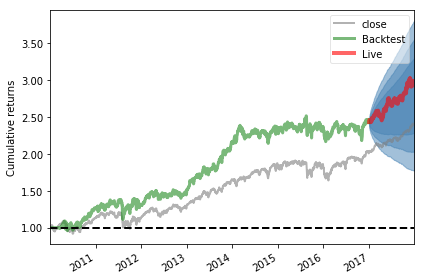

In [25]:
pf.plotting.plot_rolling_returns(returns=returns, 
                                 factor_returns=benchmark_ret, 
                                 live_start_date='20170101',
                                 cone_std=(1.0, 1.5, 2.0))
plt.tight_layout();

Entire data start date: 2010-01-04
Entire data end date: 2017-12-29
Backtest months: 95


Backtest
Annual return          14.6%
Cumulative returns    197.7%
Annual volatility      16.9%
Sharpe ratio            0.89
Calmar ratio            0.75
Stability               0.92
Max drawdown          -19.5%
Omega ratio             1.18
Sortino ratio           1.27
Skew                   -0.28
Kurtosis                5.43
Tail ratio              1.01
Daily value at risk    -2.1%
Gross leverage          1.00
Daily turnover          8.8%
Alpha                   0.03
Beta                    1.00

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  19.50 2011-07-22  2011-08-08    2011-10-28   
1                                  13.91 2015-08-17  2016-01-20    2017-02-14   
2                                  12.21 2010-04-26  2010-05-20    2010-09-16   
3                                  10.57 2011-11-08  2011-11-25    2012-02-06   
4                                  10.27 2014-03-04  2014-10-16    2015-02-23   

Worst drawdown periods Duration  
0                            71  
1                           392  
2                           104  
3                            65  
4                           255

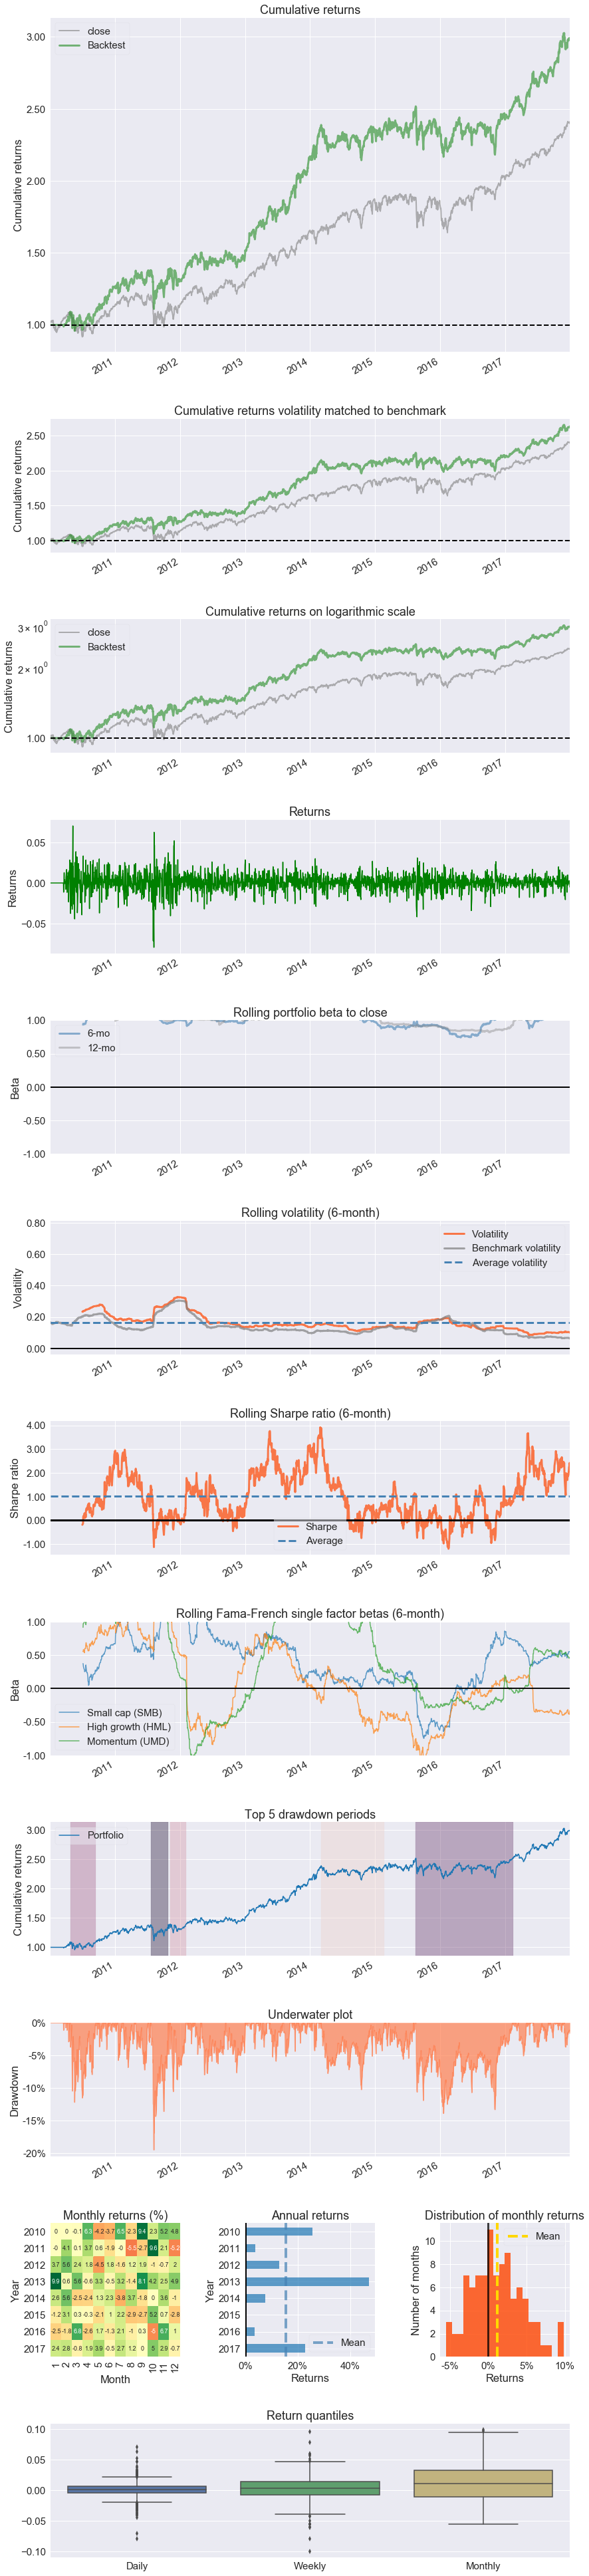

In [17]:
pf.create_returns_tear_sheet(returns=returns, transactions=transactions, positions=positions, benchmark_rets=benchmark_ret)

Entire data start date: 2010-01-04
Entire data end date: 2017-12-29
In-sample months: 83
Out-of-sample months: 11


All In-sample Out-of-sample
Annual return         14.6%     13.5%         22.9%
Cumulative returns   197.7%    142.5%         22.8%
Annual volatility     16.9%     17.7%          9.6%
Sharpe ratio           0.89      0.80          2.18
Calmar ratio           0.75      0.69          4.49
Stability              0.92      0.91          0.93
Max drawdown         -19.5%    -19.5%         -5.1%
Omega ratio            1.18      1.16          1.45
Sortino ratio          1.27      1.15          3.22
Skew                  -0.28     -0.27         -0.50
Kurtosis               5.43      4.95          1.64
Tail ratio             1.01      1.04          0.88
Daily value at risk   -2.1%     -2.2%         -1.1%
Gross leverage         1.00      1.00          1.00
Daily turnover         8.8%      8.8%          8.8%
Alpha                  0.03      0.03          0.02
Beta                   1.00      0.99          1.06

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  19.50 2011-07-22  2011-08-08    2011-10-28   
1                                  13.91 2015-08-17  2016-01-20    2017-02-14   
2                                  12.21 2010-04-26  2010-05-20    2010-09-16   
3                                  10.57 2011-11-08  2011-11-25    2012-02-06   
4                                  10.27 2014-03-04  2014-10-16    2015-02-23   

Worst drawdown periods Duration  
0                            71  
1                           392  
2                           104  
3                            65  
4                           255

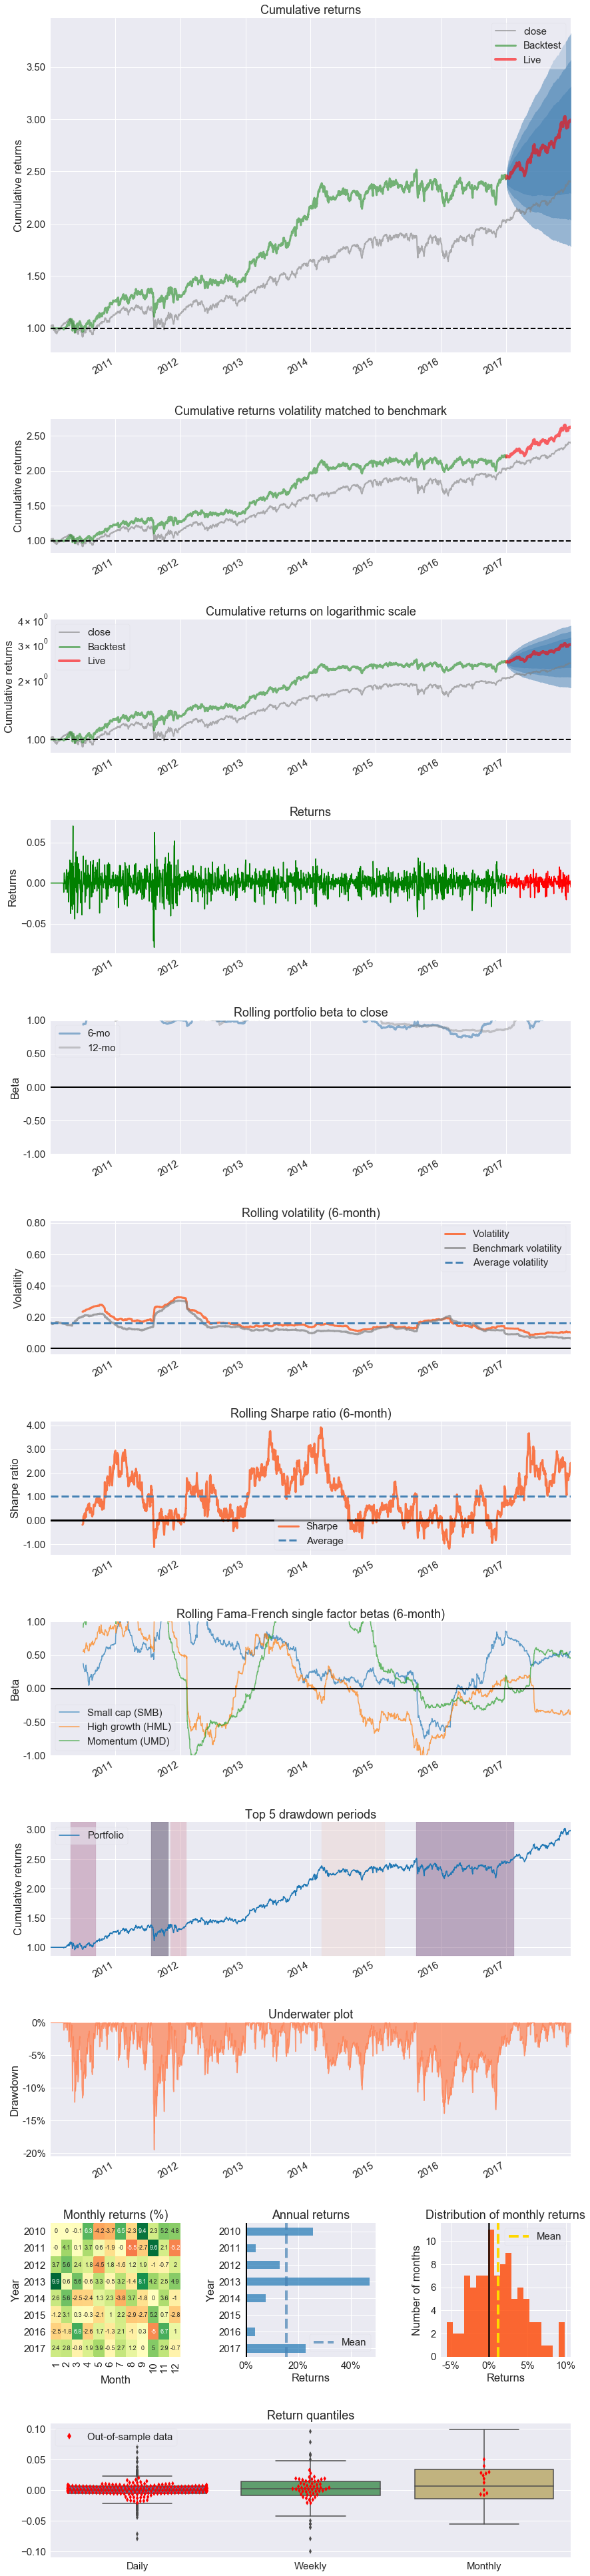

Stress Events                       mean    min   max
US downgrade/European Debt Crisis  0.22% -7.93% 6.25%
Fukushima                          0.18% -1.58% 2.19%
EZB IR Event                      -0.07% -1.55% 1.69%
Flash Crash                       -0.17% -3.24% 7.04%
Apr14                             -0.11% -2.01% 1.36%
Oct14                              0.01% -2.05% 2.06%
Fall2015                          -0.28% -4.17% 3.10%
Recovery                           0.06% -7.93% 7.04%
New Normal                         0.06% -4.17% 3.10%

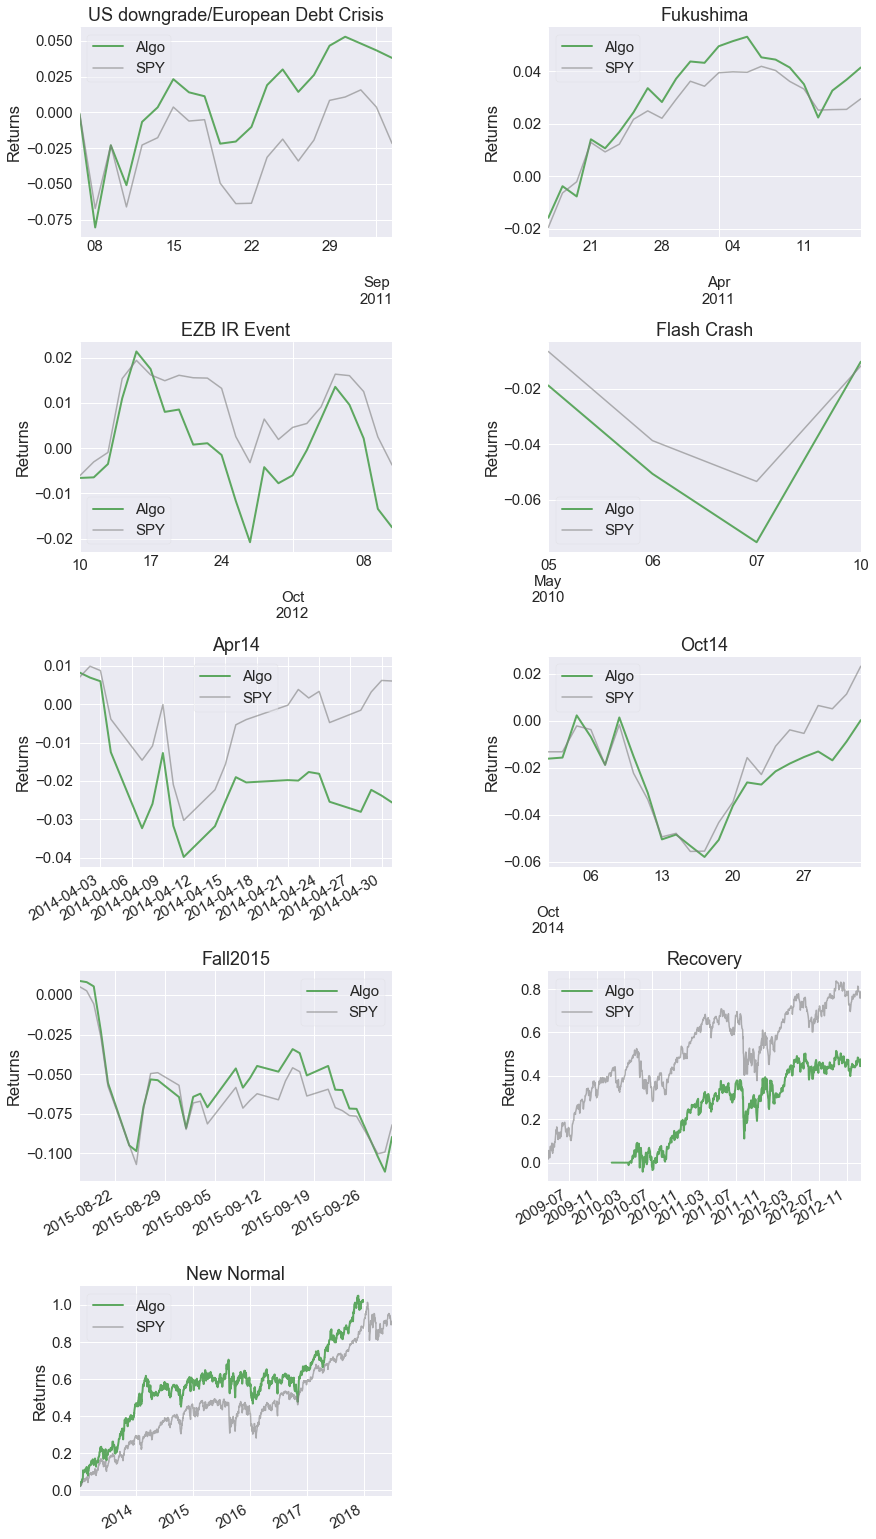

Top 10 long positions of all time    max
NEM                               13.75%
MCD                               13.39%
TJX                               13.19%
ED                                13.19%
MNST                              13.19%
ALXN                              12.70%
AVGO                              12.48%
EQT                               11.25%
COG                               10.12%
HRL                                9.74%

Top 10 short positions of all time    max
AMP                                -6.53%
MMM                                -6.30%
ROP                                -5.73%

Top 10 positions of all time    max
NEM                          13.75%
MCD                          13.39%
TJX                          13.19%
ED                           13.19%
MNST                         13.19%
ALXN                         12.70%
AVGO                         12.48%
EQT                          11.25%
COG                          10.12%
HRL                           9.74%

All positions ever held    max
NEM                     13.75%
MCD                     13.39%
TJX                     13.19%
ED                      13.19%
MNST                    13.19%
ALXN                    12.70%
AVGO                    12.48%
EQT                     11.25%
COG                     10.12%
HRL                      9.74%
DLTR                     9.57%
CME                      9.54%
ANTM                     9.37%
TRIP                     9.35%
HFC                      9.34%
EXPE                     9.24%
MSFT                     9.12%
TIF                      9.05%
V                        9.03%
WDC                      8.95%
AKAM                     8.95%
URI                      8.91%
DLR                      8.91%
KORS                     8.88%
FIS                      8.88%
STZ                      8.85%
ANSS                     8.80%
HD                       8.79%
NKTR                     8.76%
FB                       8.75%
...                        ...
PNW                      5.02%
NFX                      4.92%
LNT                      4.91%
VZ                       4.88%
PEP                      4.86%
GIS                      4.86%
MRK                      4.85%
AEP                      4.84%
FOXA                     4.83%
T                        4.81%
ES                       4.80%
CSCO                     4.80%
XLNX                     4.76%
PEG                      4.75%
L                        4.73%
BMY                      4.67%
MAA                      4.59%
K                        4.59%
CMG                      4.57%
ESRX                     4.57%
MAT                      4.54%
EXC                      4.52%
ISRG                     4.40%
M                        4.36%
REG                      4.32%
SCG                      4.31%
KHC                      4.30%
EVHC                     3.49%
GOOGL                    3.10%
GOOG                     3.09%

[341 rows x 1 columns]

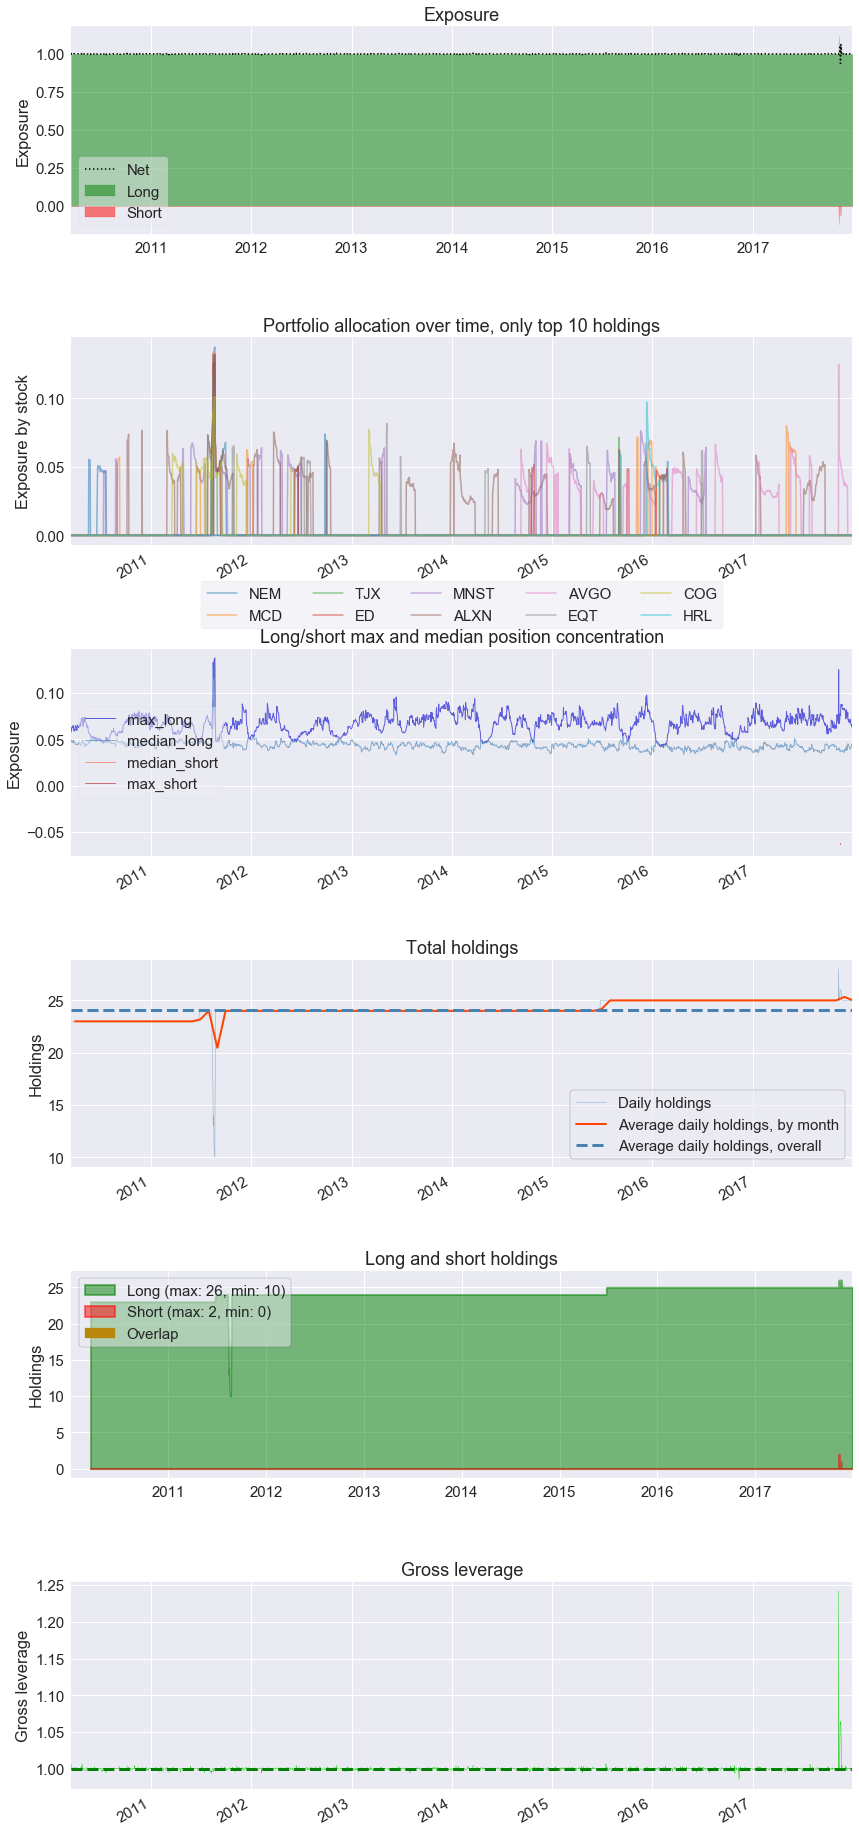

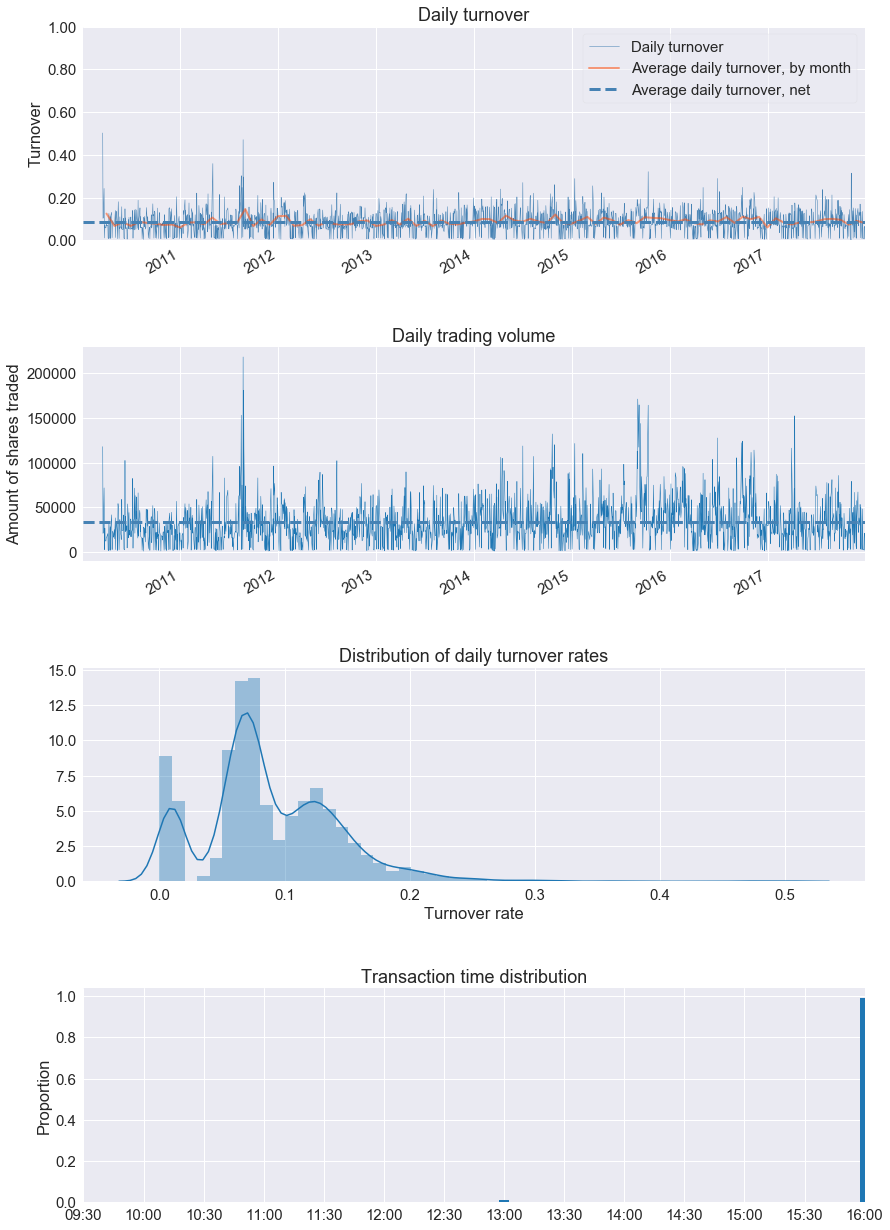

Summary stats                All trades  Short trades  Long trades
Total number of round_trips    27607.00         67.00     27540.00
Percent profitable                 0.71          0.36         0.71
Winning round_trips            19466.00         24.00     19442.00
Losing round_trips              8124.00         42.00      8082.00
Even round_trips                  17.00          1.00        16.00

PnL stats                   All trades  Short trades   Long trades
Total profit              $12026642.97  $-2410050.88  $14436693.85
Gross profit              $64432907.54    $556245.86  $63876661.68
Gross loss               $-52406264.57  $-2966296.74 $-49439967.83
Profit factor                    $1.23         $0.19         $1.29
Avg. trade net profit          $435.64    $-35970.91       $524.21
Avg. winning trade            $3310.02     $23176.91      $3285.50
Avg. losing trade            $-6450.80    $-70626.11     $-6117.29
Ratio Avg. Win:Avg. Loss         $0.51         $0.33         $0.54
Largest winning trade      $1045399.16     $98217.90   $1045399.16
Largest losing trade       $-773444.32   $-230167.20   $-773444.32

Duration stats                 All trades             Short trades  \
Avg duration      23 days 06:43:23.991777 157 days 18:54:37.597014   
Median duration          15 days 00:00:00         63 days 00:00:00   
Longest duration       1258 days 01:00:00       1258 days 01:00:00   
Shortest duration         0 days 03:00:01          0 days 20:59:59   

Duration stats                Long trades  
Avg duration      22 days 22:52:10.980464  
Median duration          15 days 00:00:00  
Longest duration        161 days 00:00:00  
Shortest duration         0 days 03:00:01

Return stats                    All trades  Short trades  Long trades
Avg returns all round_trips          0.00%        -0.16%        0.00%
Avg returns winning                  0.02%         0.09%        0.02%
Avg returns losing                  -0.03%        -0.30%       -0.03%
Median returns all round_trips       0.00%        -0.09%        0.00%
Median returns winning               0.00%         0.00%        0.00%
Median returns losing               -0.00%        -0.26%       -0.00%
Largest winning trade                3.50%         0.38%        3.50%
Largest losing trade                -3.34%        -1.10%       -3.34%

Symbol stats                      AAL    AAP   AAPL   ABBV    ABC   ABMD  \
Avg returns all round_trips     0.08% -0.00%  0.00%  0.02% -0.01%  0.01%   
Avg returns winning             0.14%  0.02%  0.01%  0.03%  0.02%  0.03%   
Avg returns losing             -0.01% -0.03% -0.03% -0.00% -0.02% -0.04%   
Median returns all round_trips  0.01%  0.00%  0.00%  0.00% -0.00%  0.00%   
Median returns winning          0.03%  0.00%  0.00%  0.00%  0.00%  0.01%   
Median returns losing          -0.00% -0.00% -0.00% -0.00% -0.00% -0.00%   
Largest winning trade           0.81%  0.26%  0.16%  0.16%  0.08%  0.31%   
Largest losing trade           -0.03% -0.81% -0.34% -0.01% -0.26% -0.64%   

Symbol stats                      ACN   ADBE    ADP    ADS  ...      WHR  \
Avg returns all round_trips    -0.03%  0.00%  0.00% -0.01%  ...    0.00%   
Avg returns winning             0.00%  0.01%  0.01%  0.01%  ...    0.02%   
Avg returns losing             -0.06% -0.02% -0.01% -0.04%  ...   -0.03%   
Median returns all round_trips -0.00%  0.00%  0.00%  0.00%  ...    0.00%   
Median returns winning          0.00%  0.00%  0.01%  0.00%  ...    0.01%   
Median returns losing          -0.00% -0.00% -0.01% -0.00%  ...   -0.00%   
Largest winning trade           0.01%  0.20%  0.02%  0.30%  ...    0.53%   
Largest losing trade           -0.24% -0.10% -0.01% -0.99%  ...   -0.45%   

Symbol stats                     WLTW    WMB    WMT   WYNN    XEC   XLNX  \
Avg returns all round_trips    -0.02%  0.01%  0.02%  0.00%  0.00%  0.02%   
Avg returns winning             0.00%  0.01%  0.02%  0.02%  0.02%  0.03%   
Avg returns losing             -0.02% -0.00% -0.00% -0.04% -0.04% -0.00%   
Median returns all round_trips -0.00%  0.00%  0.00%  0.00%  0.00%  0.01%   
Median returns winning          0.00%  0.00%  0.00%  0.01%  0.01%  0.03%   
Median returns losing          -0.00% -0.00% -0.00% -0.00% -0.00% -0.00%   
Largest winning trade           0.00%  0.08%  0.53%  0.34%  0.61%  0.06%   
Largest losing trade           -0.10% -0.00% -0.00% -0.82% -0.42% -0.00%   

Symbol stats                      XOM    YUM    ZBH  
Avg returns all round_trips    -0.00%  0.02%  0.02%  
Avg returns winning             0.12%  0.02%  0.02%  
Avg returns losing             -0.02% -0.00% -0.01%  
Median returns all round_trips -0.00%  0.00%  0.00%  
Median returns winning          0.12%  0.00%  0.00%  
Median returns losing          -0.01% -0.00% -0.00%  
Largest winning trade           0.12%  0.19%  0.21%  
Largest losing trade           -0.07% -0.00% -0.03%  

[8 rows x 341 columns]

Profitability (PnL / PnL total) per name       
CHTR                                      7.64%
NFLX                                      6.56%
AMZN                                      6.16%
IPGP                                      6.07%
ALGN                                      5.52%
BA                                        5.42%
FB                                        5.05%
NVDA                                      5.04%
AZO                                       4.68%
AGN                                       4.36%
MNST                                      4.26%
MLM                                       3.88%
ROK                                       3.58%
MTD                                       3.55%
EQIX                                      3.55%
COO                                       3.33%
BLK                                       3.05%
OKE                                       3.02%
CMG                                       3.02%
SIVB                                      2.99%
ILMN                                      2.88%
SHW                                       2.83%
REGN                                      2.73%
MTB                                       2.57%
CI                                        2.26%
PRU                                       2.26%
UHS                                       2.22%
HII                                       2.20%
NOC                                       2.11%
AMG                                       2.09%
...                                         ...
HES                                      -1.20%
VNO                                      -1.21%
MMM                                      -1.23%
QRVO                                     -1.30%
NSC                                      -1.33%
AVB                                      -1.40%
NOV                                      -1.41%
IBM                                      -1.48%
ANTM                                     -1.53%
NKTR                                     -1.54%
COTY                                     -1.72%
ADS                                      -1.73%
EQT                                      -1.84%
CF                                       -2.12%
APC                                      -2.20%
DLTR                                     -2.28%
MA                                       -2.29%
HP                                       -2.53%
VMC                                      -2.76%
GPN                                      -2.97%
HUM                                      -3.21%
AVGO                                     -3.38%
EOG                                      -3.50%
VRTX                                     -3.61%
TDG                                      -3.94%
CELG                                     -6.24%
TSCO                                     -7.16%
ROST                                     -7.47%
CNC                                      -8.83%
EW                                       -8.86%

[341 rows x 1 columns]

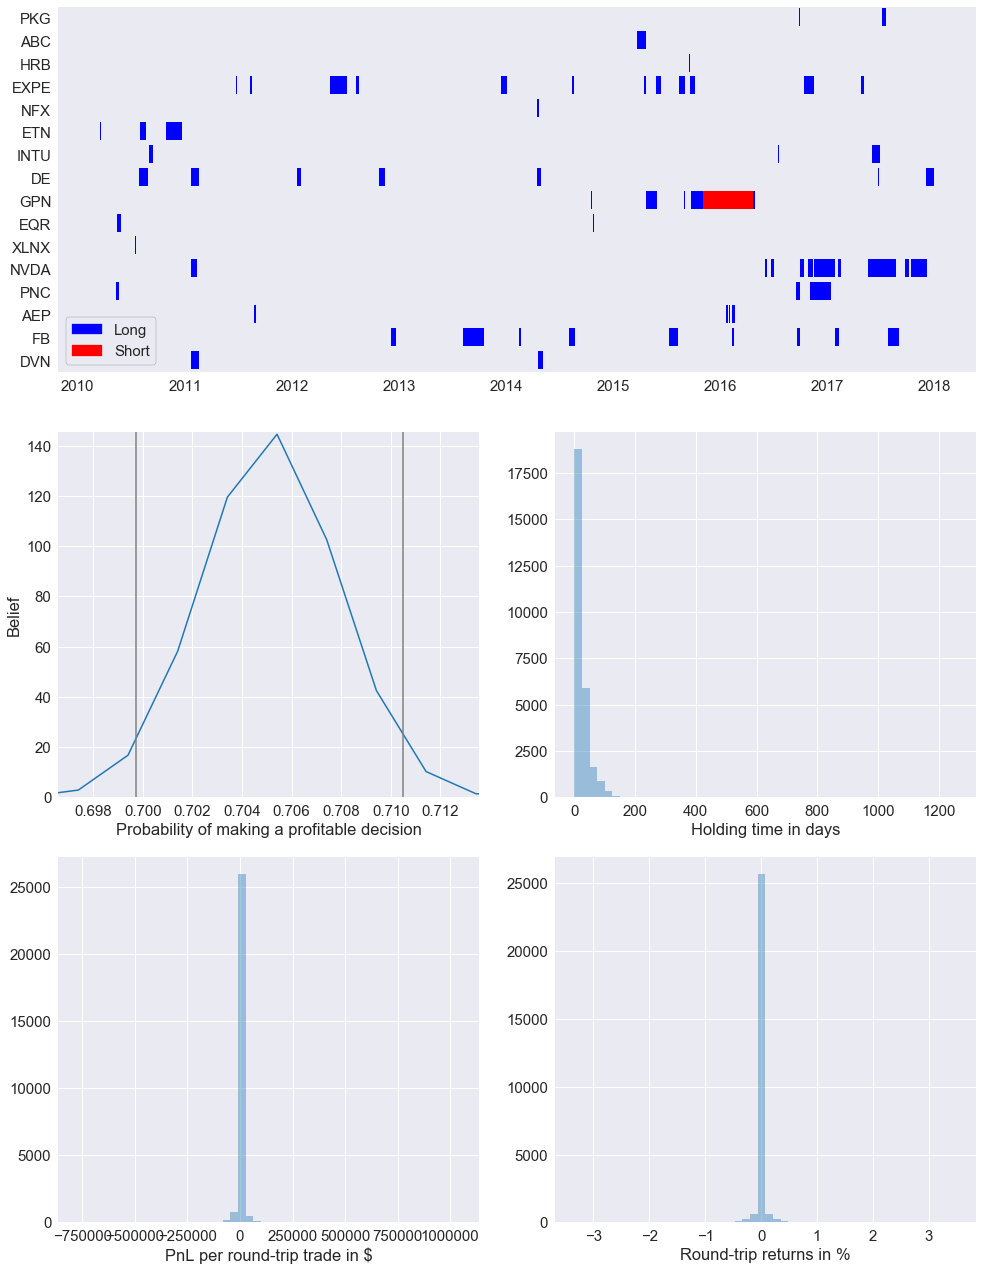

In [13]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          live_start_date='2017-01-01', 
                          round_trips=True,
                          benchmark_rets=benchmark_ret)

## Converting data from zipline to pyfolio

In [9]:
returns, positions, transactions = \
    pf.utils.extract_rets_pos_txn_from_zipline(backtest)

In [10]:
positions.columns = STOCKS + ['cash']

## Data structures used by pyfolio

In [11]:
returns.tail()

2009-12-24 00:00:00+00:00    0.000989
2009-12-28 00:00:00+00:00    0.008174
2009-12-29 00:00:00+00:00    0.007428
2009-12-30 00:00:00+00:00    0.002472
2009-12-31 00:00:00+00:00   -0.018984
Name: returns, dtype: float64

In [12]:
positions.tail()

AMD         CERN          COST         DELL  \
index                                                                         
2009-12-24 00:00:00+00:00      0.00      0.00000  28116.291654      0.00000   
2009-12-28 00:00:00+00:00      0.00      0.00000  26444.895165      0.00000   
2009-12-29 00:00:00+00:00      0.00      0.00000  18547.461768      0.00000   
2009-12-30 00:00:00+00:00   3178.44      0.00000  31364.795616  63294.65464   
2009-12-31 00:00:00+00:00  44363.44  20816.10101  63315.443592  18114.05960   

                                     GPS          INTC           MMM  \
index                                                                  
2009-12-24 00:00:00+00:00   86022.143403  40522.266140  17288.084400   
2009-12-28 00:00:00+00:00   91778.156400  38402.193192  17039.652084   
2009-12-29 00:00:00+00:00  108639.828380  47874.339058      0.000000   
2009-12-30 00:00:00+00:00   53188.785870  26018.584921      0.000000   
2009-12-31 00:00:00+00:00   26346.752400      0.000000      0.000000   

                                  cash  
index                                   
2009-12-24 00:00:00+00:00   261.648675  
2009-12-28 00:00:00+00:00   -46.731967  
2009-12-29 00:00:00+00:00  -153.847015  
2009-12-30 00:00:00+00:00 -1705.100847  
2009-12-31 00:00:00+00:00  -944.218331

In [13]:
transactions.tail()

txn_volume  txn_shares
2009-12-24 00:00:00+00:00   29064.589481        1381
2009-12-28 00:00:00+00:00    8794.514054         405
2009-12-29 00:00:00+00:00   49996.978324        1765
2009-12-30 00:00:00+00:00  157158.874704        9233
2009-12-31 00:00:00+00:00  189609.809608       11946

## Create all tear-sheets pyfolio has to offer

In [14]:
sector_map = {'AMD': 'Technology',
              'CERN': 'Technology',
              'DELL': 'Technology',
              'INTC': 'Technology',
              'COST': 'Services',
              'GPS': 'Services',
              'MMM': 'Industrial Goods'}

Entire data start date: 2004-01-09
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69
                   Backtest  Out_of_Sample  All_History
annual_return          0.12           0.16         0.12
annual_volatility      0.26           0.22         0.25
sharpe_ratio           0.48           0.74         0.48
calmar_ratio           0.21           2.23         0.21
stability              0.00           0.04         0.01
max_drawdown          -0.60          -0.07        -0.60
omega_ratio            1.09           1.13         1.09
sortino_ratio          0.71           1.04         0.71
skewness               0.28          -0.29         0.27
kurtosis               4.07           0.36         4.03
alpha                  0.09          -0.06         0.09
beta                   0.81           1.20         0.81

Worst Drawdown Periods
   net drawdown in %  peak date valley date recovery date duration
0              59.52 2007-11-06  2008-11-20           NaT      NaN


/home/wiecki/miniconda3/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


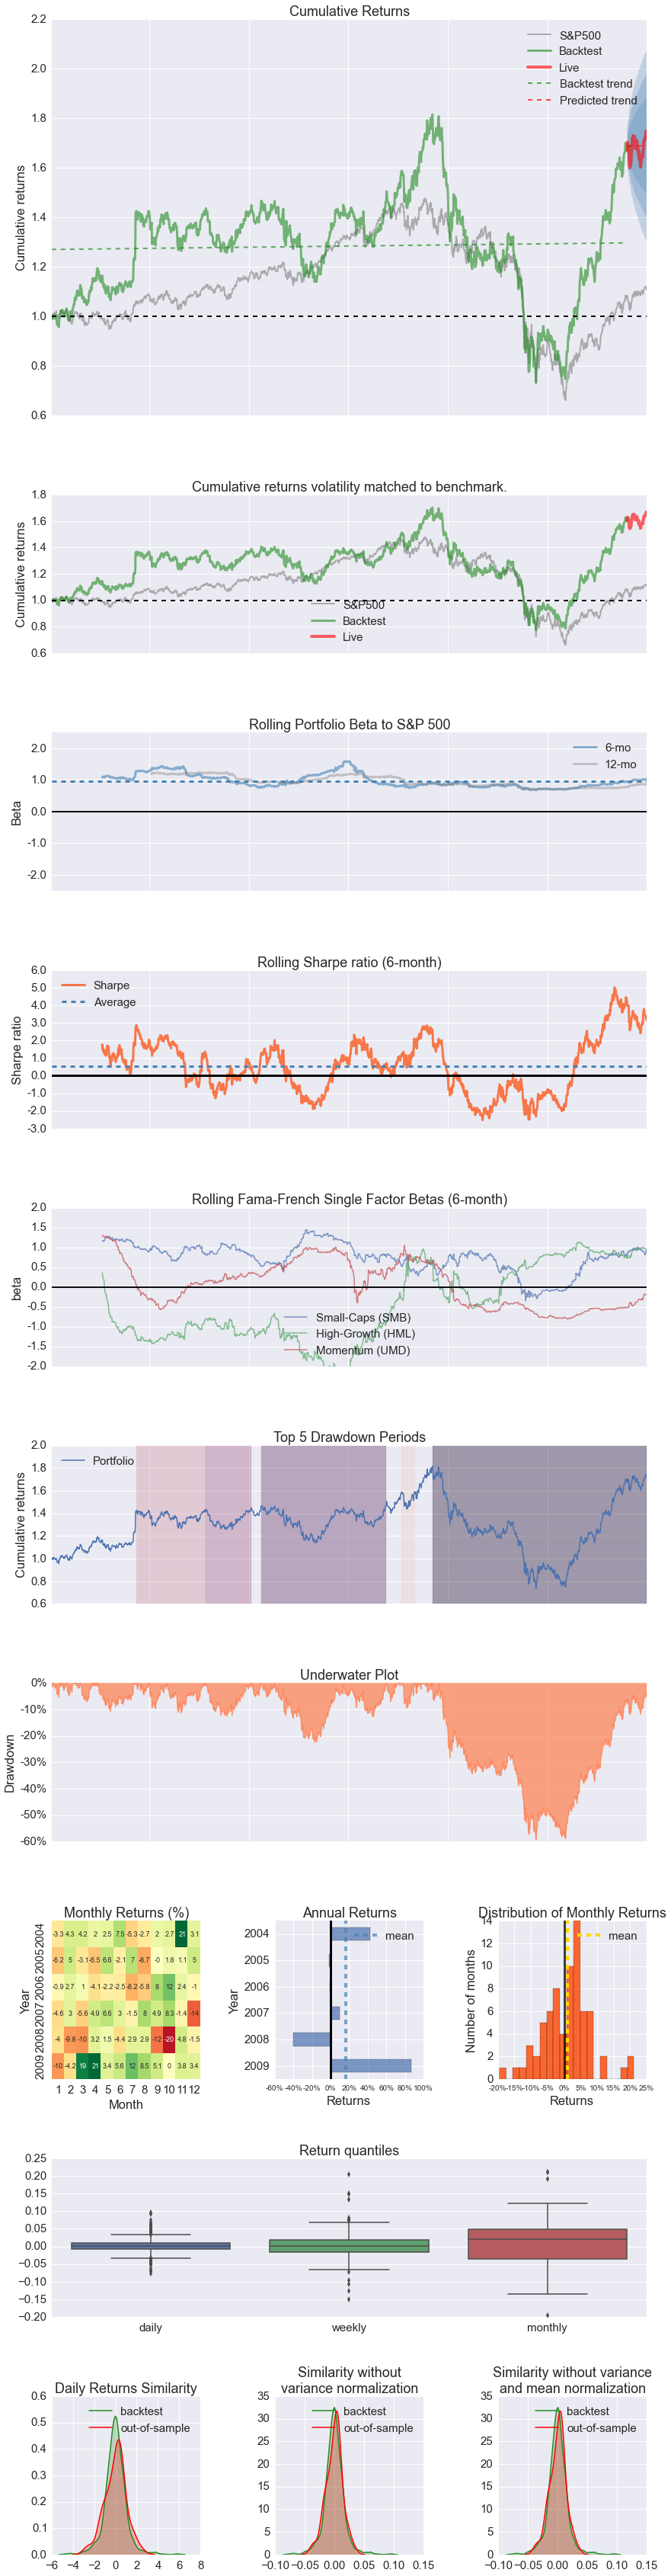


Stress Events
          mean    min    max
Lehmann -0.003 -0.044  0.044
Aug07    0.003 -0.030  0.030
Sept08  -0.006 -0.043  0.040
2009Q1  -0.004 -0.050  0.034
2009Q2   0.007 -0.038  0.062


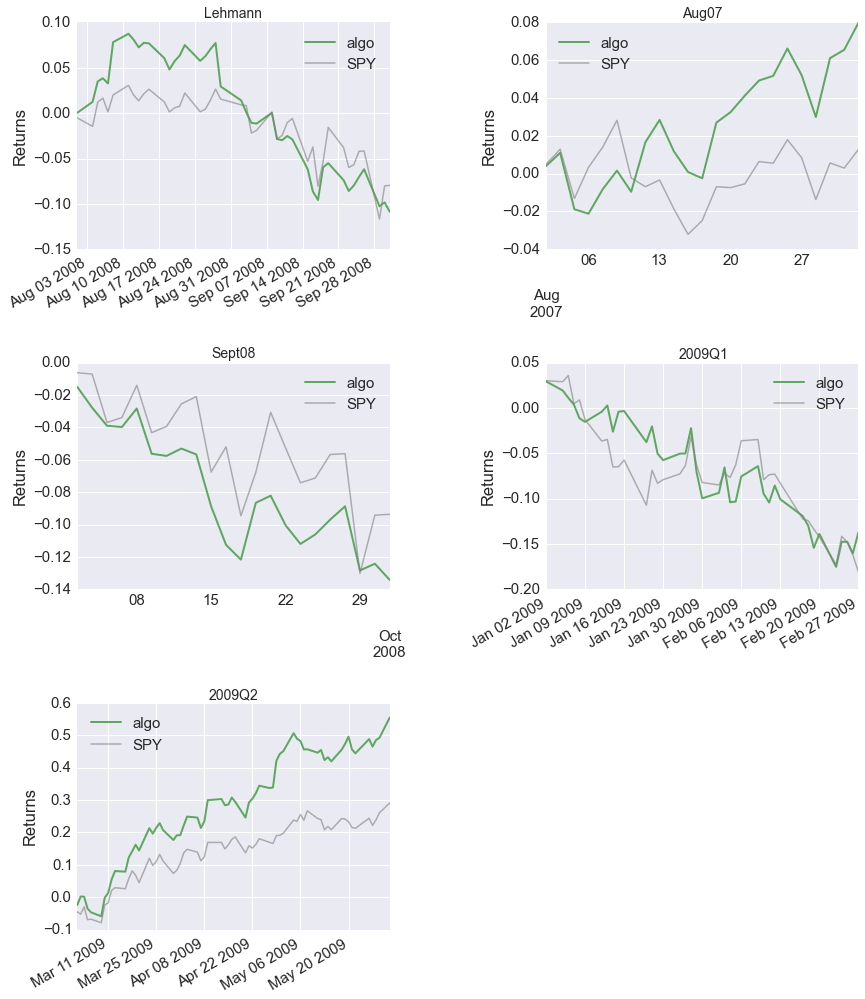



Top 10 long positions of all time (and max%)
['COST' 'MMM' 'CERN' 'DELL' 'AMD' 'INTC' 'GPS']
[ 0.993  0.911  0.845  0.717  0.709  0.666  0.62 ]


Top 10 short positions of all time (and max%)
[]
[]


Top 10 positions of all time (and max%)
['COST' 'MMM' 'CERN' 'DELL' 'AMD' 'INTC' 'GPS']
[ 0.993  0.911  0.845  0.717  0.709  0.666  0.62 ]


All positions ever held
['COST' 'MMM' 'CERN' 'DELL' 'AMD' 'INTC' 'GPS']
[ 0.993  0.911  0.845  0.717  0.709  0.666  0.62 ]




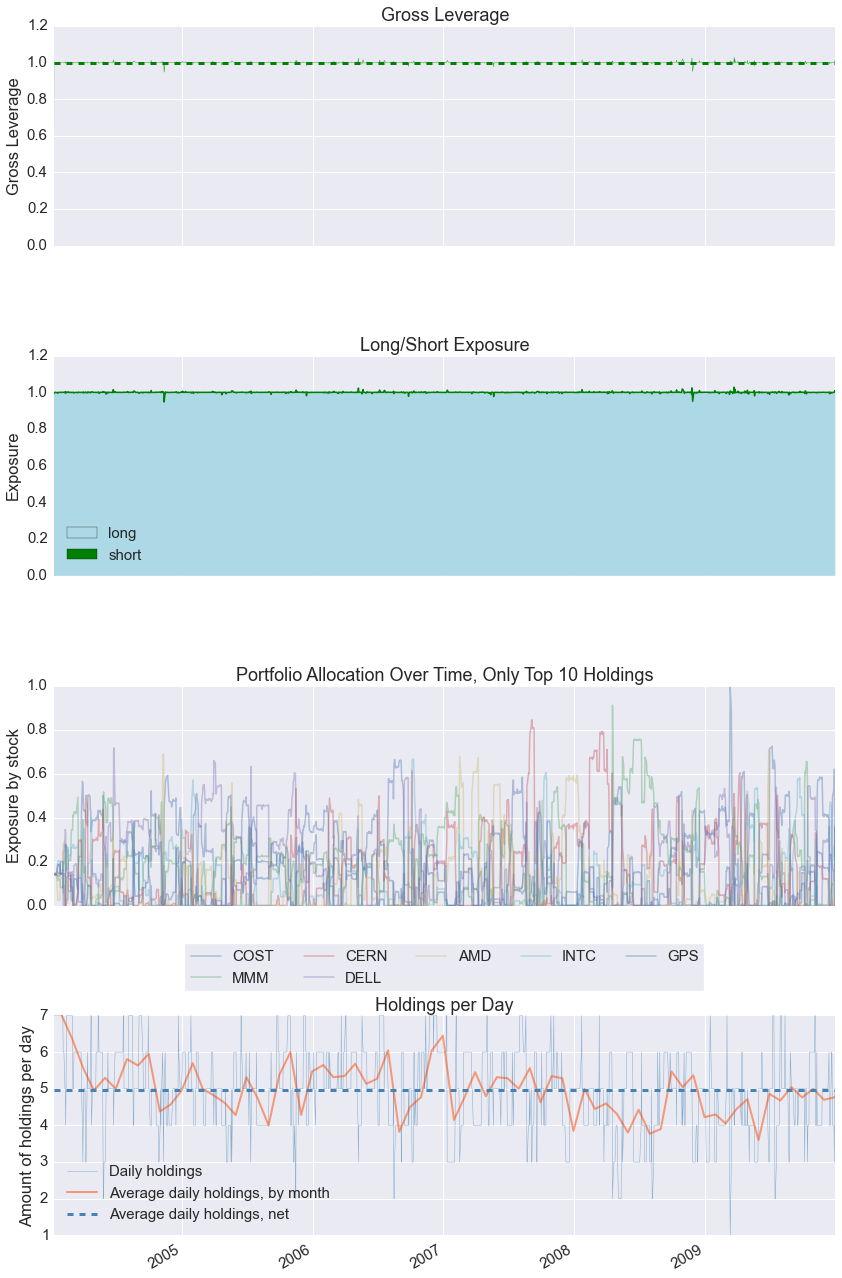

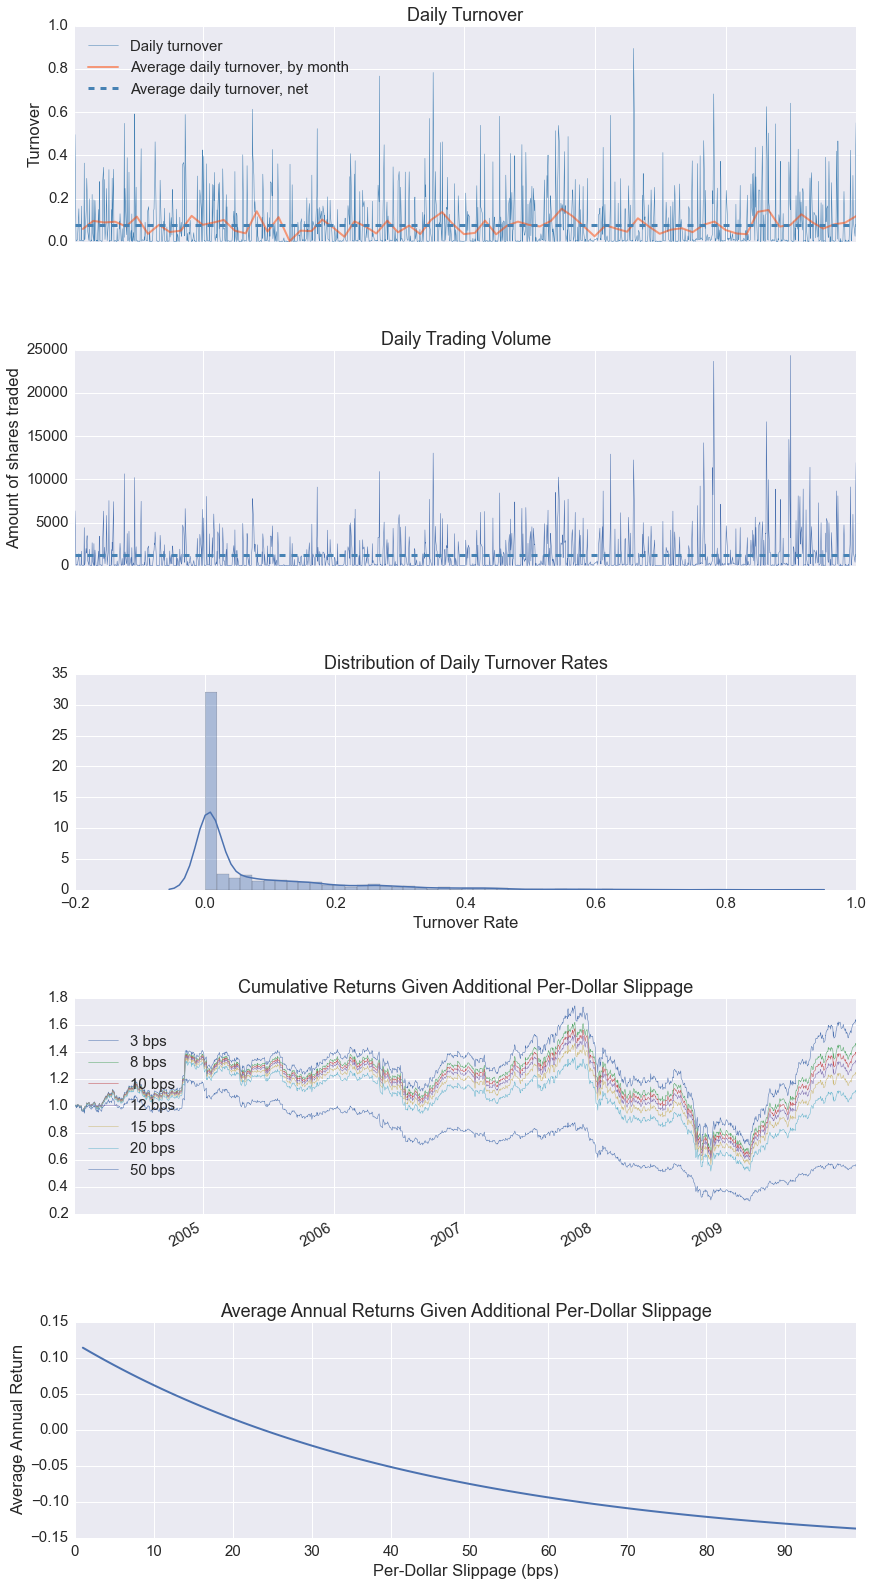

In [24]:
oos_date = '2009-10-21'

pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions,
                          live_start_date=oos_date,
                          slippage=0.1,
                          sector_mappings=sector_map)

## Pyfolio can also be used as a library

Levels of API
* Tear sheets call individual plotting functions in `pyfolio.plotting`
* Plotting functions call individual statistical functions in `pyfolio.timeseries` 

In [17]:
# Show overview of pyfolio.plotting submodule
[f for f in dir(pf.plotting) if 'plot_' in f]

['plot_annual_returns',
 'plot_daily_returns_similarity',
 'plot_daily_turnover_hist',
 'plot_daily_volume',
 'plot_drawdown_periods',
 'plot_drawdown_underwater',
 'plot_exposures',
 'plot_gross_leverage',
 'plot_holdings',
 'plot_monthly_returns_dist',
 'plot_monthly_returns_heatmap',
 'plot_return_quantiles',
 'plot_rolling_beta',
 'plot_rolling_fama_french',
 'plot_rolling_returns',
 'plot_rolling_sharpe',
 'plot_sector_allocations',
 'plot_slippage_sensitivity',
 'plot_slippage_sweep',
 'plot_turnover',
 'show_and_plot_top_positions']

In [18]:
pf.timeseries.sharpe_ratio(stock_rets)

1.0745672736176346

## These functions have many more options and detailed descriptions

In [19]:
help(pf.plotting.plot_rolling_returns)

Help on function plot_rolling_returns in module pyfolio.plotting:

plot_rolling_returns(returns, factor_returns=None, live_start_date=None, cone_std=None, legend_loc='best', volatility_match=False, ax=None, **kwargs)
    Plots cumulative rolling returns versus some benchmarks'.
    
    Backtest returns are in green, and out-of-sample (live trading)
    returns are in red.
    
    Additionally, a linear cone plot may be added to the out-of-sample
    returns region.
    
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of a risk factor.
         - This is in the same style as returns.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading, after
        its backtest period.
    cone_std : float, or tuple, optional
        If float, The sta

## Using pyfolio in Quantopian Research

Go to: https://www.quantopian.com/research/notebooks/Tutorial%20-%20pyfolio.ipynb

## Bayesian analysis in pyfolio

* Sneak-peek into ongoing research.
* Focus is on comparing backtest (in-sample) and forward-test (out-of-sample; OOS).
* Sophisticated statistical modeling taking uncertainty into account.
* Uses T-distribution to model returns (instead of normal).
* Relies on [PyMC3](http://pymc-devs.github.io/pymc3/).

Running T model
 [-----------------100%-----------------] 2000 of 2000 complete in 5.9 sec
Finished T model (required 32.18 seconds).

Running BEST model
 [-----------------100%-----------------] 2000 of 2000 complete in 6.8 sec
Finished BEST model (required 47.93 seconds).

Finished plotting Bayesian cone (required 0.13 seconds).

Finished plotting BEST results (required 0.84 seconds).

Finished computing Bayesian predictions (required 0.17 seconds).

Finished plotting Bayesian VaRs estimate (required 0.07 seconds).

Running alpha beta model
 [-----------------100%-----------------] 2000 of 2000 complete in 3.8 sec
Finished running alpha beta model (required 27.80 seconds).

Finished plotting alpha beta model (required 0.16 seconds).

Total runtime was 109.28 seconds.


/home/wiecki/miniconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


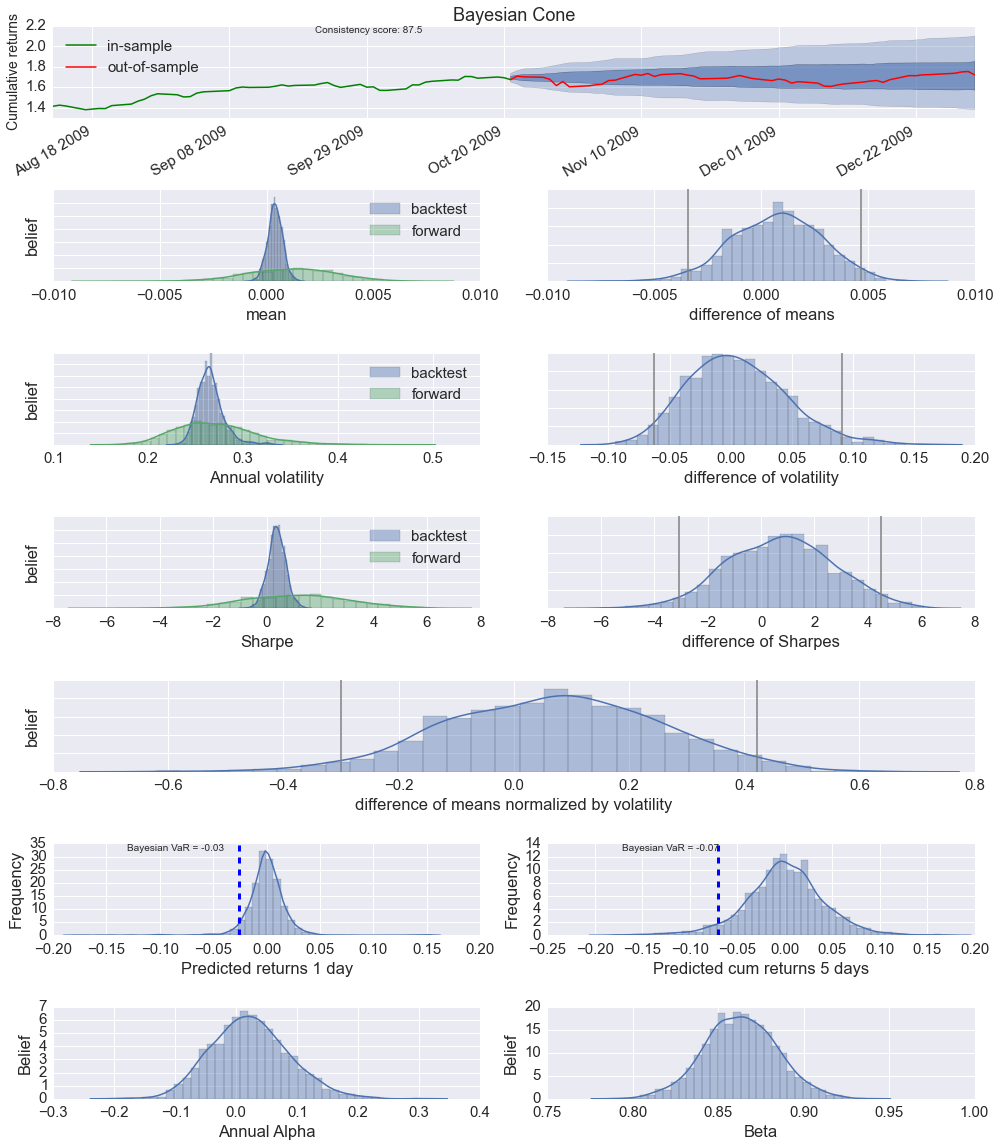

In [21]:
oos_date = '2009-10-21'
pf.create_bayesian_tear_sheet(returns, live_start_date=oos_date)

# For more information:
* Accompanying blog post: [http://blog.quantopian.com/bayesian-cone/](http://blog.quantopian.com/bayesian-cone/)
* Bayesian Methods for Hackers: [http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
* PyMC3: [http://pymc-devs.github.io/pymc3](http://pymc-devs.github.io/pymc3)

# Summary

* Pyfolio bundles various useful analyses and includes advanced statistical modeling.
* Jess Stauth's webinar: https://www.youtube.com/watch?v=-VmZAlBWUko
* Still young -- please contribute: https://github.com/quantopian/pyfolio/labels/help%20wanted
* Bugs: https://github.com/quantopian/pyfolio/issues
* Twitter: [@twiecki](https://twitter.com/twiecki)